# Comparación de dos o más poblaciones: análisis de la varianza (ANOVA de un factor)

Fisher introdujo el Análisis de la Varianza como técnica para __analizar la influencia que distintos factores podrían tener sobre una variable respuesta__, es decir, para tratar de explicar el comportamiento de variable aleatoria (por ejemplo `total_litres_of_pure_alcohol`) debido a la influencia de distintos factores (por ejemplo `continent`). 

> Solo vamos a trabajar __el modelo de efectos fijos__ que asume que los datos provienen de poblaciones normales las cuales podrían diferir únicamente en sus medias.

Populating the interactive namespace from numpy and matplotlib


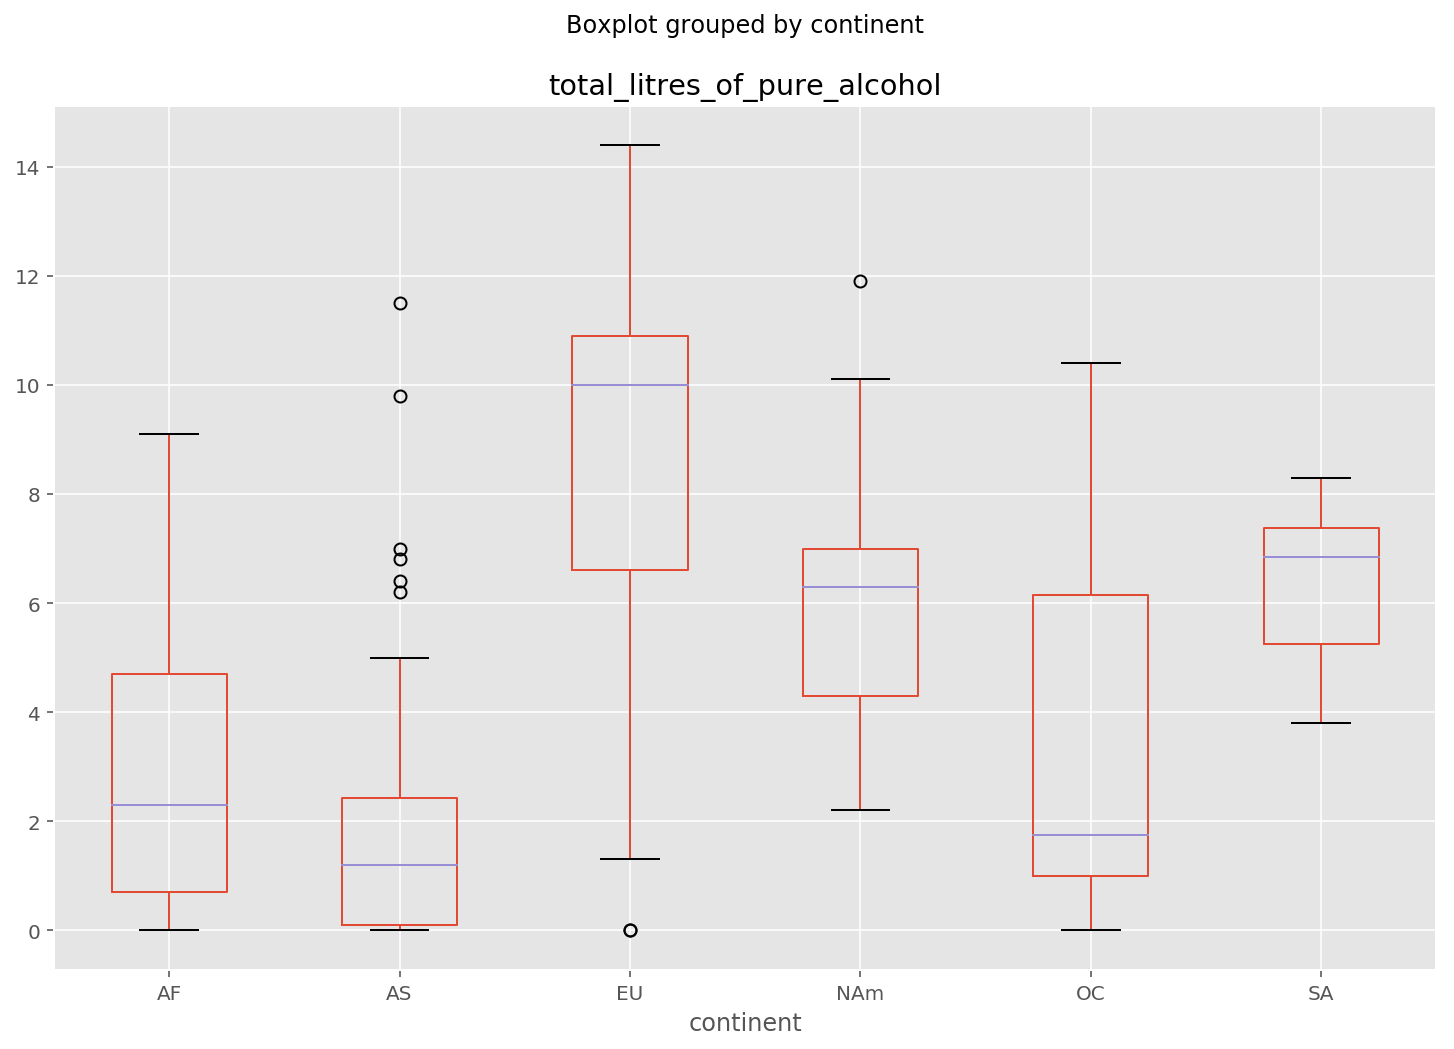

In [3]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

import pandas as pd

drinks = pd.read_csv('https://raw.githubusercontent.com/AngelBerihuete/introstats/master/datasets/drinks.csv')
drinks.boxplot('total_litres_of_pure_alcohol', by='continent', figsize=(12, 8));

## ANOVA de un factor

__[Ejemplo]__ Se pretende estudiar el consumo medio de litros de alcohol puro por individuo y por año en función del continente donde esté ubicado el individuo. 

La hipótesis a contrastar sería 

$$ 
\begin{cases}
H_0: & \mu_1 = \mu_2 = \dots = \mu_k \\
H_1: & \mbox{ al menos una es distinta }
\end{cases}
$$

Consideraremos un factor $F$ (continente) que puede presentarse bajo un cierto número de niveles (AS, AF, EU, etc.) y que actúa sobre una variable respuesta $X$ (litros de alcohol puro por individuo y año). El modelo que consideraremos será

$$x_{ij} = \mu_j + e_{ij} \qquad e_{ij} \sim \mathcal{N}(0, \sigma)$$

Donde 

* $x_{ij}$ es la observación j-ésima correspondiente al nivel i-ésimo del factor.
* $\mu_i$ es una constante común a todas las observaciones correspondientes al nivel $i$ del factor. 
* $e_{ij}$ es la parte de la variable observada que no queda expliada por el factor $F$ (error experimental).

__Admitiremos__ que 

* Las variable $e_{ij}$ son independientes e identicamente distribuidas según una $\mathcal{N}(0,\sigma)$.
* Para cada nivel $i$ las observaciones $x_{ij}$ siguen distribuciones independientes con igual varainza (homocedasticidad) $\mathcal{N}(\mu_i, \sigma)$.

Es decir, vamos a comparar en un mismo contraste las medias de varias poblaciones __Normales, independientes y con varianzas iguales__ a través de un contraste (unilateral). La técnica se basa en la descomposición de la variabilidad de la variable observada en dos causas:

1. Diferencia __entre grupos__ ocasionada por el factor en estudio (continente)
2. Variabilidad __dentro de los grupos__ consecuencia de la influencia de otros factores (distintos al factor continente).


El estadístico de contraste a utilizar es

$$F_{exp} = \cfrac{MCE}{MCD}$$

y región crítica

$$RC= \{F_{exp} > F_{1-\alpha} (k-1, N-k) \} $$

siendo MCE y MCD las medias de la *TABLA DEL ANOVA*:

<img src='figures/TablaANOVA.png',style="width: 512px;"\>

* SCE: Medida de la variabilidad entre muestras
* SCD: Medida de la variabilidad dentro de las muestras, debido al error
* SCT = SCE + SCD, variabilidad total


donde

<img src='figures/TablaANOVA0.png',style="width: 512px;"\>





In [4]:
drinks.set_index('continent').head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
continent,,,,,
AS,Afghanistan,0,0,0,0.0
EU,Albania,89,132,54,4.9
AF,Algeria,25,0,14,0.7
EU,Andorra,245,138,312,12.4
AF,Angola,217,57,45,5.9


In [5]:
drinks.set_index('continent', inplace=True)

muestraAS = drinks.loc['AS',:].total_litres_of_pure_alcohol
muestraAF = drinks.loc['AF',:].total_litres_of_pure_alcohol
muestraEU = drinks.loc['EU',:].total_litres_of_pure_alcohol

In [6]:
from scipy import stats

F, pvalue = stats.f_oneway(muestraAS, muestraAF, muestraEU)
print("Estadísitico y p-valor:              F = %g  p-valor = %g" % (F, pvalue))

Estadísitico y p-valor:              F = 65.3552  p-valor = 9.82074e-21


#### Otra forma de realizar el ANOVA

In [7]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

muestras = drinks.loc[['AS', 'AF' , 'EU'], :]
muestras.reset_index(inplace=True)

modelo = ols('total_litres_of_pure_alcohol ~ continent', data=muestras).fit()
tabla_anova = sm.stats.anova_lm(modelo, typ=2)
print(tabla_anova)

                sum_sq     df          F        PR(>F)
continent  1119.759242    2.0  65.355176  9.820742e-21
Residual   1190.774350  139.0        NaN           NaN


/home/angel/anaconda2/envs/introstats/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Tamaño del efecto

Al igual que el coeficiente de determinación $R^2$ en la regresión lineal, podemos calcular el **tamaño  del  efecto** $\eta^2$ para el ANOVA: porcentaje  de  varianza explicada por el efecto de la variable independiente. 

Por ejemplo, si el valor de $\eta^2 = 0.4846$, podremos decir que el 48.46% de las diferencias encontradas entre los grupos se atribuye al efecto de la intervención o tratamiento.

In [11]:
tabla_anova['sum_sq'][0]/(tabla_anova['sum_sq'][0]+tabla_anova['sum_sq'][1])

0.48463231429563997

## ¿Qué pasa si el contraste ANOVA ha sido significativo? ¿Cuáles son las medias que son diferentes? Comparaciones múltiples

Existen test para contrastar las diferentes comparaciones entre niveles cuando el test ANOVA resulta significativo.

In [8]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

multiComp = MultiComparison(muestras['total_litres_of_pure_alcohol'], muestras['continent'])
print((multiComp.tukeyhsd().summary()))
print((multiComp.groupsunique))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  AF     AS   -0.8371  -2.2514 0.5772 False 
  AF     EU    5.6102   4.2045 7.0159  True 
  AS     EU    6.4473   4.9771 7.9175  True 
--------------------------------------------
['AF' 'AS' 'EU']


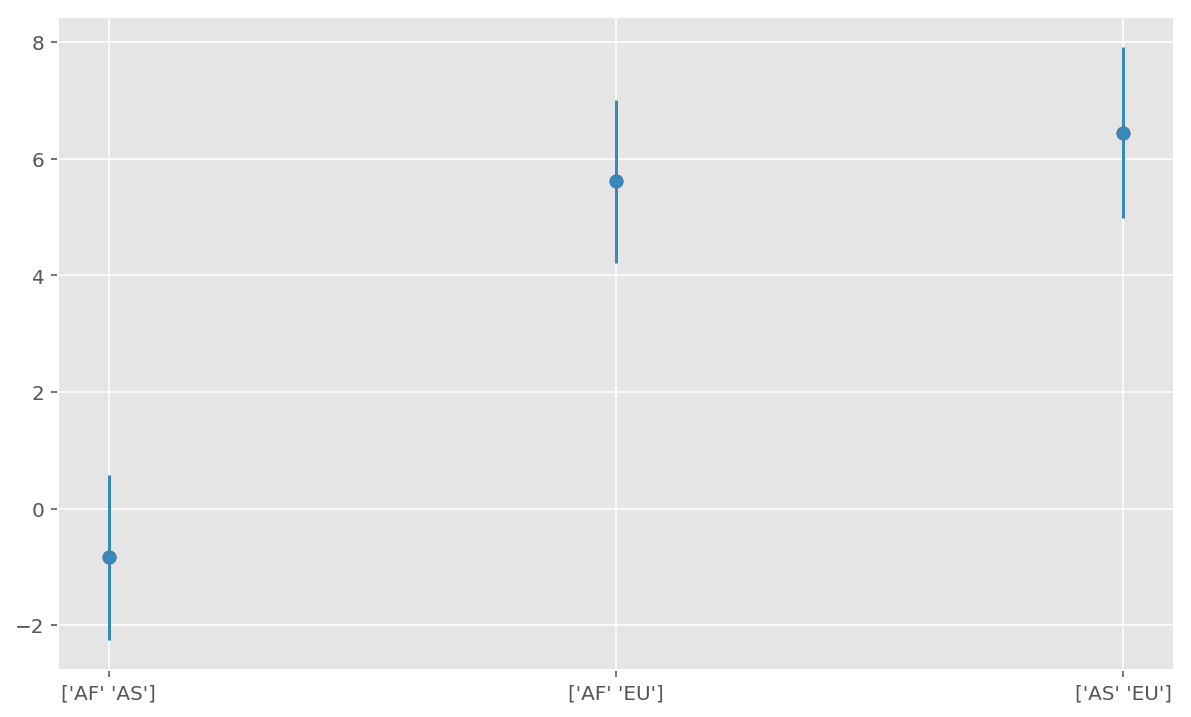

In [9]:
xvals = np.arange(len((multiComp.groupsunique)))
res = pairwise_tukeyhsd(muestras['total_litres_of_pure_alcohol'], muestras['continent'])
errors = np.ravel(np.diff(res.confint)/2)

plt.plot(xvals, res.meandiffs, 'o')
plt.errorbar(xvals, res.meandiffs, yerr=errors, fmt='o')
    
# Put on labels
pair_labels = multiComp.groupsunique[np.column_stack(res._multicomp.pairindices)]
plt.xticks(xvals, pair_labels);

# ¿Y si fallan las suposiciones de partida? Entonces Kruskal-Wallis

Recordemos que vamos a comparar en un mismo contraste las medias de varias poblaciones __Normales, independientes y con varianzas iguales__ ¿Se cumplen estas condiciones?

**Hipótesis 1: muestras independientes**.

Si el experimento está bien diseñado, daremos por supuesta la independiencia.

In [9]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(modelo.resid)

2.167654021550236

**Hipótesis 2: Cada una de las muestras debe provenir de una distribución normal**

In [11]:
from scipy.stats import shapiro

shapiro(muestraAS)
#shapiro(muestraAF)
#shapiro(muestraEU)

(0.7710681557655334, 7.248301585605077e-07)

**Hipótesis 3: Homocedasticidad** Es decir, distribuciones normales deben tener varianzas iguales.

In [12]:
from scipy.stats import levene

levene(muestraAS, muestraAF, muestraEU)

LeveneResult(statistic=0.86718681818823518, pvalue=0.42239210419686046)

Como la **hipótesis 2** ha fallado tendremos que aplicar un contraste NO paramétrico: **Test de KrusKal-Wallis**

* Vamos a probar si un grupo de datos proviene de la misma población.
* Se emplea cuando se quieren comparar tres o más poblaciones
* Es una extensión de la prueba de la U de Mann-Whitney para 3 o más grupos.
* No requiere supuesto de normalidad
* No requiere supuesto de varianzas iguales (homogeneidad de varianzas)
* Compara esencialmente los rangos promedios observados para las k muestras, con los esperados bajo H0


In [13]:
from scipy.stats import kruskal
kruskal(muestraAS, muestraAF, muestraEU)

KruskalResult(statistic=57.778486025776246, pvalue=2.841588412600444e-13)

__[Ejercicio]__ 

Se pretende averiguar si el número de días de recuperación de un enfermo
después de una operación depende del tipo de rehabilitación que siguen los
enfermos. Para tres tipos de rehabilitación, los datos obtenidos son:

|Tipos| Días de recuperación |
|:-----|:----------------------|
|Tipo 1| 28, 27, 30, 29, 40, 41, 32, 25|
|Tipo 2| 25, 23, 19, 34, 35, 27, 40, 39, 37, 28|
|Tipo 3|  23, 19, 13, 21, 23, 29, 25|


**Suponiendo Normalidad e igualdad de varianzas en los grupos**, contrastar $(\alpha=0.05)$ si las tres formas de rehabilitación son igualmente eficaces.


In [12]:
data = pd.DataFrame({
    'dias':[28, 27, 30, 29, 40, 41, 32, 25, 25, 23, 19, 34, 35, 27, 40, 39, 37, 28, 23, 19, 13, 21, 23, 29, 25],
    'tipo': np.repeat(["Tipo1", "Tipo2", "Tipo3"], [8, 10, 7], axis = 0)
})

modelo=ols('dias ~ tipo', data=data).fit() #Specify C for Categorical
tabla_anova = sm.stats.anova_lm(modelo, typ=2)
print(tabla_anova)

              sum_sq    df         F    PR(>F)
tipo      429.282857   2.0  5.421749  0.012182
Residual  870.957143  22.0       NaN       NaN


Como $p-valor=0.012182 < 0.05 = \alpha$ el contraste es significativo. Luego se rechaza $H_0$ y por tanto los tipos de rehabilitación son diferentes